In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm
import cvxopt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
R = np.array([8.,6.,4.])
# P = row_normalize([np.random.rand(ch)/2])[0]
# E = np.random.rand(en,ch)/2
# R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .3
print(P)
print(E)
print(R)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]


In [4]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.18360655737704915
6.775956284153006 1.0 [0.] True 0.3
[0.38797814 0.61202186 0.        ]


In [5]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

3 3 0.3 6.775956284153006 0.18360655737704915
[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[0.38797814 0.61202186 0.        ]


In [7]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],bounds=(.05,1.0),method='revised simplex',options={'tol': 1.0e-1})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(steady_state_prob(P))])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)

[0.05454545 0.89090909 0.05454545] 0.22061714769720744


In [12]:
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30

In [35]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.01 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = [0]; enc = [rd.randint(en)];chnl = [rd.randint(ch)]
avg_rate = []
# markov extra param
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
step = 50
lr = 0.1
eps = .5
eps_min = 0.01

In [36]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
rn = rd.rand()
tolx = tol
sprob = steady_state_prob(p[-1])
for t in range(1,50000):
    enc.append(sample(x[-1].transpose()[0]))
    if rn < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    if t%step == 0:
        # markov part
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if rn < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(x[-1]*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]]) #here
        temp = np.copy(p[-1])
        lr = min(lr,1.0/float(t+1)) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        # OPLB
        r.append(dot(x[-1],Rn))
        c.append(np.max([dot(x[-1].transpose(),i) for i in np.matmul(p[-1],E.transpose())]))
        copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
        xopt = x[-1] - (dot(x[-1],e0)*e0)
        sigopt += np.matmul(xopt,xopt.transpose())
        uopt += (copt*xopt)
        muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
        A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
        betat = Ra*math.sqrt(en*math.log((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
        d = -2*alfa_c*betat
        l = alfa_c*betat*(1+pow(dot(e0,e0),2.0))
        C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
        if t%(step*step) == 0:
            tolx += (tol-np.mean(c))
        sol = qclp_solver(A,C,x0,R,en,tolx)
        rn = rd.rand()
        x.append(sol[0])
        avg_rate.append(dot(x[-1],Rn)*R_sum)
        print(t,avg_rate[-1],sol[1],tolx)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(ub,betat)

50 6.251152871078342 0.21767764355888458 0.3
100 6.256207864454699 0.21875888084657777 0.3
150 6.2607667712302275 0.21982251772023448 0.3
200 6.264287763848621 0.22091528205048522 0.3
250 6.266575213699418 0.22204745907760565 0.3
300 6.270688077491082 0.22293552713420925 0.3
350 6.274482689449811 0.22381047852848437 0.3
400 6.277717234495449 0.2246832900728014 0.3
450 6.2809840862658834 0.22551132267790927 0.3
500 6.283964970294164 0.22632051103227419 0.3
550 6.286758615823119 0.2271011164498548 0.3
600 6.288540960820407 0.22789354980825915 0.3
650 6.288208348647794 0.22872522195448652 0.3
700 6.290568495276171 0.22936064963340108 0.3
750 6.292724271801643 0.2299786544128105 0.3
800 6.294751206805049 0.230576152795446 0.3
850 6.296478737745212 0.23115315971693434 0.3
900 6.2982020746624805 0.23170359876035443 0.3
950 6.299804423194456 0.23223343954089598 0.3
1000 6.301256166330348 0.2327433026737532 0.3
1050 6.302622031657824 0.2332322828364521 0.3
1100 6.303792141333395 0.233703347446

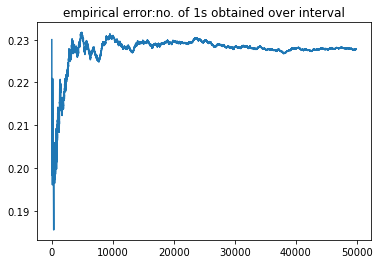

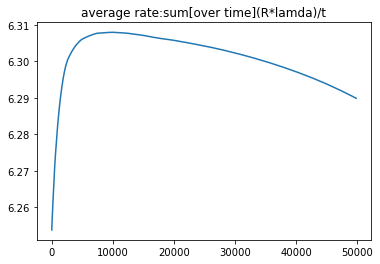

In [37]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = []
for i in avg_rate:
    rate_plot.extend([i]*step)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [38]:
print(x0.flatten())
print(x[-1].flatten(),error_plot[-1],rate_plot[-1])
print(org_x,tol,dot(org_x,R))

[0.05454545 0.89090909 0.05454545]
[1.23252714e-01 8.76747286e-01 1.30511487e-63] 0.22780455609112168 6.289910065061097
[0.38797814 0.61202186 0.        ] 0.3 6.775956284153006


16.65164349459588


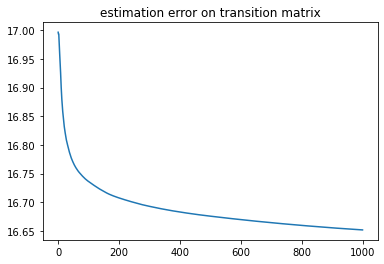

In [39]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(P-p[i]))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

[0.32767514 0.32659944 0.34572542]
[0.29508197 0.2704918  0.43442623]
0.11145750438384502


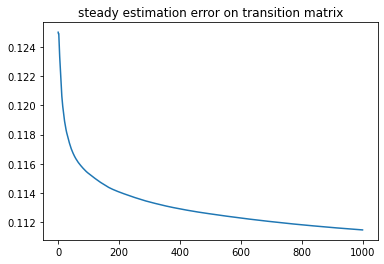

In [40]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))))
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show() 

19.848236345435147


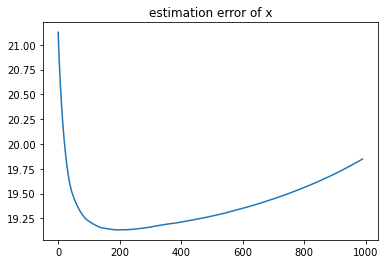

In [41]:
err = []; s = 3
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[10:])
plt.title('estimation error of x')
plt.show()

In [57]:
# Rough

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4